In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import sys
import os
sys.path.append(os.path.abspath(".."))  # Add project root to Python path
from src.optimiser import EquityOptimiser
from download_data import load_optimization_data
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings("ignore")

def turn_on_logging():
    warnings.resetwarnings()
    import logging

    # Configure logging
    logging.basicConfig(
        level=logging.INFO,  # Set logging level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
        format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
        handlers=[
            logging.StreamHandler(sys.stdout)  # Log to notebook output
        ]
    )

## Load Data - Last 3-years SPX data

In [4]:
# Load the data
data = load_optimization_data(Path(os.path.abspath(".") + "/spx_data"), 500)
tickers = data['tickers']
expected_returns = data['expected_returns']
covariance_matrix = data['covariance_matrix']
adv = data['adv']

In [5]:
def show_results(weights, port_return, port_risk):
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Ticker': tickers,
        'Weight': weights,
        'Mean': expected_returns,
        'Variance': np.diag(covariance_matrix),
        'ADV': adv,
        'Abs Weights': np.abs(weights)
    }).sort_values('Abs Weights', ascending=False)
    print(f"Portfolio Return: {port_return:.2%}")
    print(f"Portfolio Risk: {port_risk}")
    print("Optimal Portfolio:")
    # print(results_df.head(5))  # Show top holdings
    return results_df

## What is the maximum return possible?

In [6]:
optimiser = EquityOptimiser(
    expected_returns=expected_returns,
    covariance_matrix=covariance_matrix
)

# Run optimization
weights, port_return, port_risk = optimiser.optimise_return_given_risk(99)
show_results(weights, port_return, port_risk)[:5]

Portfolio Return: 120178.43%
Portfolio Risk: 98.99999957058135
Optimal Portfolio:


,Ticker,Weight,Mean,Variance,ADV,Abs Weights
163,LNT,-267.355006,0.084540,0.044385,8.060670e+07,267.355006
80,FI,253.455596,0.339374,0.055535,3.912301e+08,253.455596
462,PNR,251.247845,0.235138,0.083089,9.468150e+07,251.247845
422,WM,-247.743391,0.195182,0.036192,2.861186e+08,247.743391
294,CMS,239.863953,0.090047,0.040503,1.270666e+08,239.863953


Note the amazing returns, but also the insane risk and the weights!!

### Let's go long only?

In [9]:
optimiser.set_weights_bound(0,1)
weights, port_return, port_risk = optimiser.optimise_return_given_risk(99)
show_results(weights, port_return, port_risk)[:5]

Portfolio Return: 134.02%
Portfolio Risk: 0.9280380933883422
Optimal Portfolio:


,Ticker,Weight,Mean,Variance,ADV,Abs Weights
412,SMCI,1.000000e+00,1.340217,0.861255,2.092584e+09,1.000000e+00
172,PLTR,3.659377e-11,1.033747,0.487787,1.474923e+09,3.659377e-11
480,VST,8.586374e-13,0.834528,0.220911,3.360270e+08,8.586374e-13
94,CEG,7.924225e-13,0.792791,0.225693,3.732599e+08,7.924225e-13
417,NVDA,7.387420e-13,0.753022,0.308577,2.270026e+10,7.387420e-13


Slightly worse than before, yet still good returns with an improved risk. Note the concentration in Top-3 stocks 

## Let's set top k limits

In [10]:
optimiser.set_top_k_limit(5, 0.6)
weights, port_return, port_risk = optimiser.optimise_return_given_risk(99)
show_results(weights, port_return, port_risk)[:5]

Portfolio Return: 96.16%
Portfolio Risk: 0.5482490537384183
Optimal Portfolio:


,Ticker,Weight,Mean,Variance,ADV,Abs Weights
412,SMCI,0.527273,1.340217,0.861255,2.092584e+09,0.527273
172,PLTR,0.018182,1.033747,0.487787,1.474923e+09,0.018182
480,VST,0.018182,0.834528,0.220911,3.360270e+08,0.018182
94,CEG,0.018182,0.792791,0.225693,3.732599e+08,0.018182
417,NVDA,0.018182,0.753022,0.308577,2.270026e+10,0.018182


Low return and risk, but a lot better with concentration

### Let's try to find and plot the Efficient Frontier

In [17]:
frontier_returns = np.array([])
frontier_risk = np.array([])
frontier_weights = np.array([[]])
for min_return in np.linspace(0.12,0.25,num=14):
    try:
        optimiser = EquityOptimiser(
            expected_returns=expected_returns,
            covariance_matrix=covariance_matrix
        )
        port_weights, port_return, port_risk = optimiser.optimise_risk_given_return(min_return)
        # print(f"min_return: {min_return}, risk: {port_risk}, return: {port_return}")
        frontier_returns = np.append(frontier_returns, port_return)
        frontier_risk = np.append(frontier_risk, port_risk)
        frontier_weights = np.append(frontier_weights, port_weights)
    except Exception as exc:
        print(f"skipping risk: {risk} because: \n {exc}")

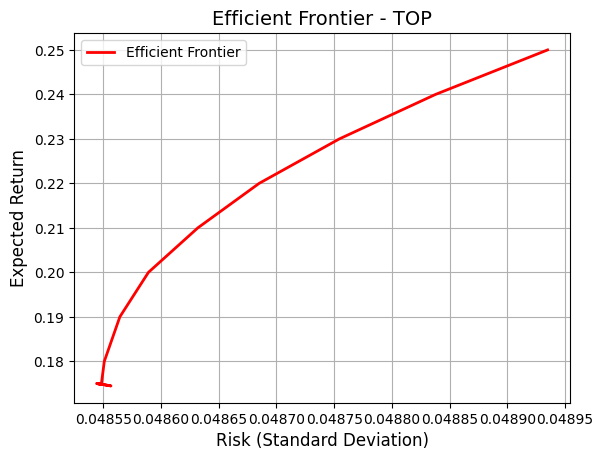

In [18]:
# Plot efficient frontier
plt.plot(
    frontier_risk,
    frontier_returns,
    color="red",
    linestyle="-",
    linewidth=2,
    label="Efficient Frontier"
)
plt.xlabel("Risk (Standard Deviation)", fontsize=12)
plt.ylabel("Expected Return", fontsize=12)
plt.title("Efficient Frontier - TOP", fontsize=14)
plt.legend()
plt.grid(True)

## Bottom (for completeness)

In [21]:
frontier_returns = np.array([])
frontier_risk = np.array([])
frontier_weights = np.array([[]])
for max_return in np.linspace(0.05,0.18, num=10):
    try:
        optimiser = EquityOptimiser(
            expected_returns=expected_returns,
            covariance_matrix=covariance_matrix
        )
        optimiser.set_min_return(-5, max_return)
        port_weights, port_return, port_risk = optimiser.optimise(return_f_=0)        
        # print(f"max_return: {max_return}, risk: {port_risk}, return: {port_return}")
        frontier_returns = np.append(frontier_returns, port_return)
        frontier_risk = np.append(frontier_risk, port_risk)
        frontier_weights = np.append(frontier_weights, port_weights)
    except Exception as exc:
        print(f"skipping risk: {risk} because: \n {exc}")


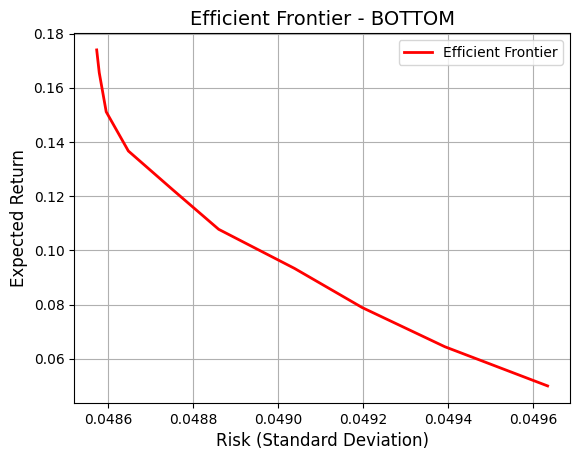

In [22]:
# Plot efficient frontier
plt.plot(
    frontier_risk,
    frontier_returns,
    color="red",
    linestyle="-",
    linewidth=2,
    label="Efficient Frontier"
)
plt.xlabel("Risk (Standard Deviation)", fontsize=12)
plt.ylabel("Expected Return", fontsize=12)
plt.title("Efficient Frontier - BOTTOM", fontsize=14)
plt.legend()
plt.grid(True)